# Liesel-GAM Demo Notebook

## Setup and Imports

In [67]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [68]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

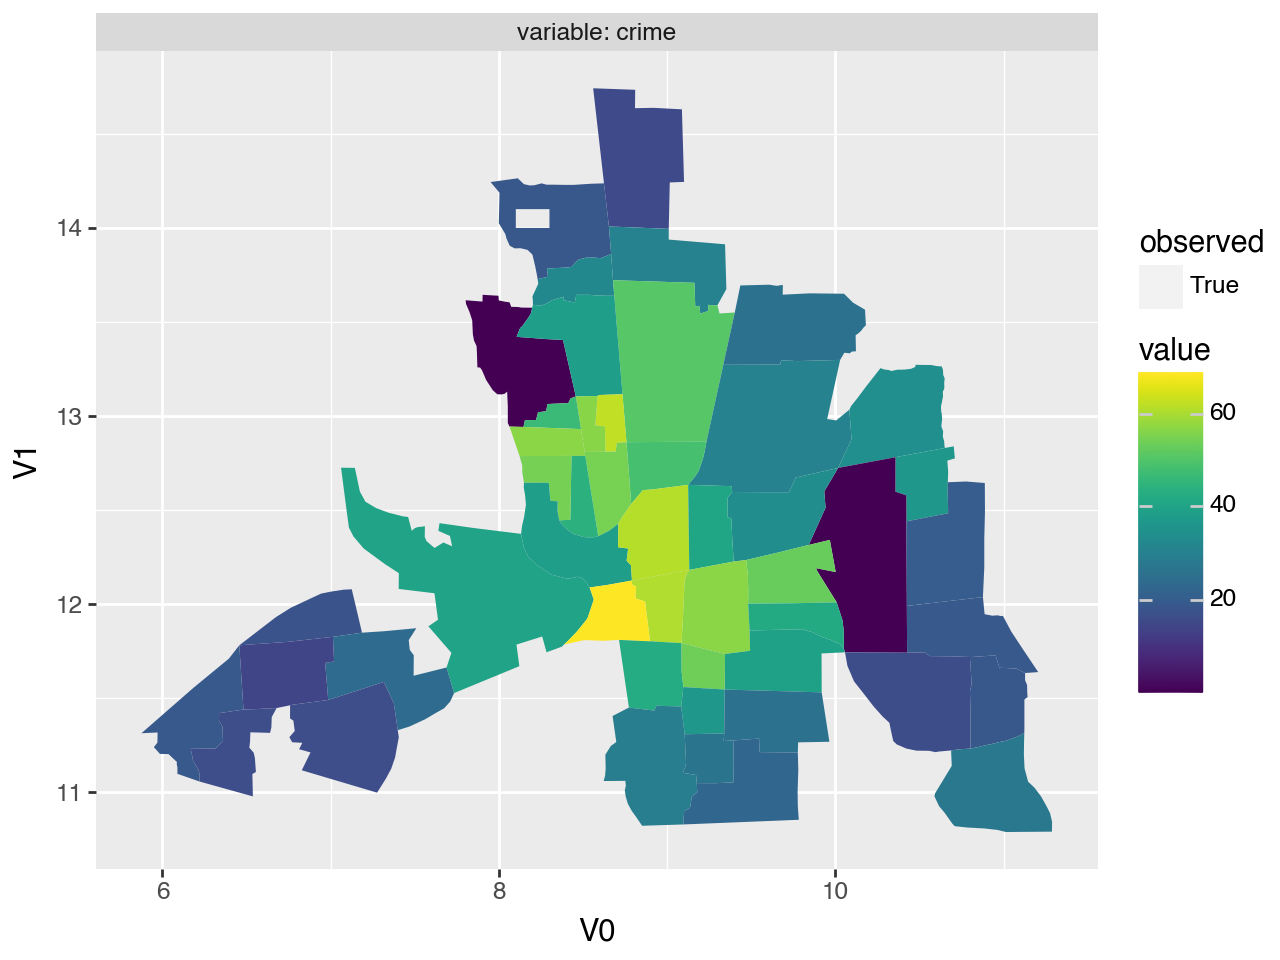

In [69]:
gam.plot_polys(region="district", which=["crime"], df=columb, polys=polys)

## Model Definition

### Setup response model

In [70]:
df = columb

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

tb = gam.TermBuilder.from_df(df)
loc += tb.mrf("district", polys=polys, factor_scale=True)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


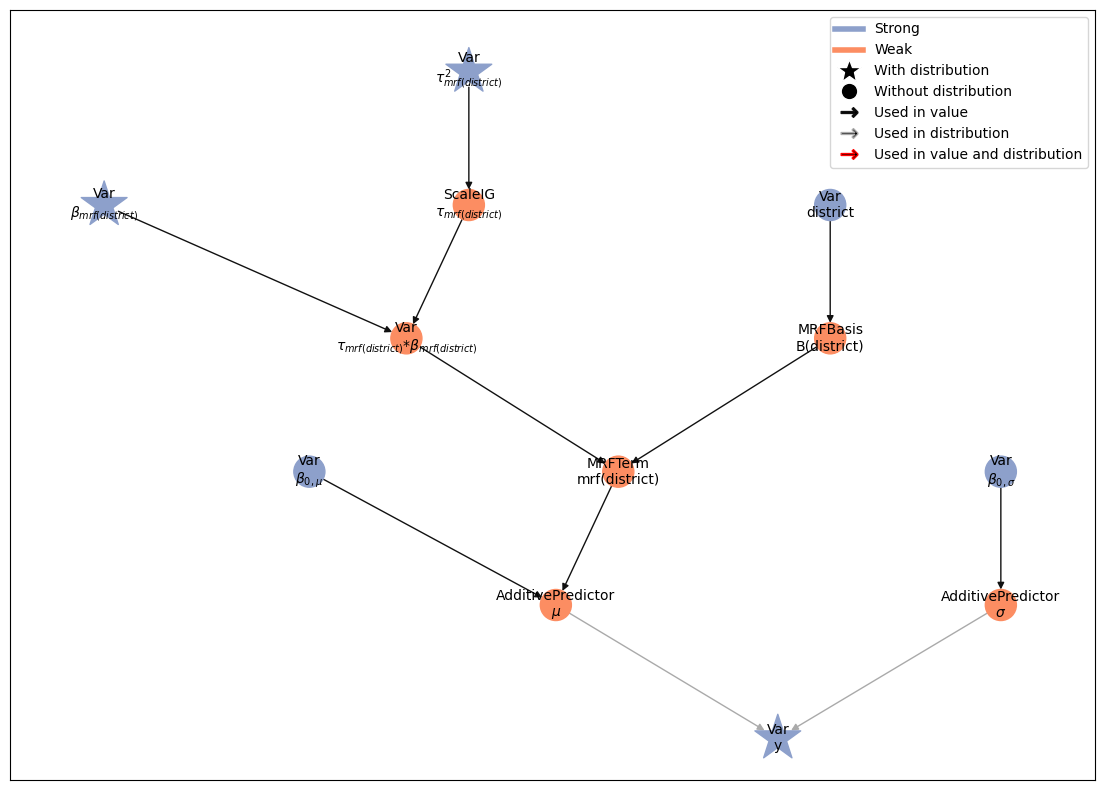

In [71]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [72]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{mrf(district)}$', '$\\tau_{mrf(district)}^2$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:02<00:00,  6.52chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1000.79chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1150.07chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose

### MCMC summary

In [73]:
summary = gs.Summary(results)
summary

Parameter summary:

                                   kernel       mean        sd     q_0.05  \
parameter                index                                              
$\beta_{0,\mu}$          ()     kernel_01  35.096340  2.328057  31.170359   
$\beta_{0,\sigma}$       ()     kernel_00   2.752954  0.174850   2.386530   
$\beta_{mrf(district)}$  (0,)   kernel_02   0.160553  1.030130  -1.544839   
                         (1,)   kernel_02   0.004423  0.985912  -1.584930   
                         (2,)   kernel_02   0.130304  0.979401  -1.491224   
                         (3,)   kernel_02   0.154070  0.985942  -1.500810   
                         (4,)   kernel_02   0.056888  0.957079  -1.523267   
                         (5,)   kernel_02  -0.013116  0.985986  -1.671782   
                         (6,)   kernel_02  -0.047901  0.969851  -1.684959   
                         (7,)   kernel_02   0.001884  0.969092  -1.607784   
                         (8,)   kernel_02  -0.038727  0.958429  -1.576383   
                         (9,)   kernel_02   0.154889  1.049214  -1.570946   
                         (10,)  kernel_02   0.042477  0.980161  -1.585905   
                         (11,)  kernel_02  -0.050713  0.966950  -1.665057   
                         (12,)  kernel_02   0.021416  0.947249  -1.525458   
                         (13,)  kernel_02  -0.004431  0.961919  -1.579009   
                         (14,)  kernel_02  -0.021674  0.973334  -1.568937   
                         (15,)  kernel_02  -0.174285  1.013221  -1.827574   
                         (16,)  kernel_02   0.066289  0.943949  -1.509822   
                         (17,)  kernel_02   0.051142  0.965553  -1.554432   
                         (18,)  kernel_02   0.062982  0.969570  -1.559262   
                         (19,)  kernel_02  -0.121986  0.987931  -1.753264   
                         (20,)  kernel_02   0.104038  0.992917  -1.573985   
                         (21,)  kernel_02   0.334356  1.054931  -1.338837   
                         (22,)  kernel_02   0.020488  0.962558  -1.547686   
                         (23,)  kernel_02  -0.042592  0.968404  -1.558173   
                         (24,)  kernel_02  -0.098463  0.994409  -1.726303   
                         (25,)  kernel_02   0.024797  0.968662  -1.584953   
                         (26,)  kernel_02  -0.079936  0.973879  -1.647773   
                         (27,)  kernel_02  -0.060451  0.983948  -1.609751   
                         (28,)  kernel_02  -0.132405  0.962075  -1.694735   
                         (29,)  kernel_02  -0.112762  0.976743  -1.700317   
                         (30,)  kernel_02   0.095666  0.961031  -1.552407   
                         (31,)  kernel_02  -0.072176  0.953413  -1.611576   
                         (32,)  kernel_02  -0.180045  0.993794  -1.781225   
                         (33,)  kernel_02   0.058486  0.960482  -1.554091   
                         (34,)  kernel_02  -0.109598  0.957269  -1.632241   
                         (35,)  kernel_02   0.146180  0.954677  -1.475198   
                         (36,)  kernel_02   0.199148  0.972499  -1.456226   
                         (37,)  kernel_02  -0.070036  0.950552  -1.630436   
                         (38,)  kernel_02  -0.058160  0.949083  -1.599313   
                         (39,)  kernel_02   0.189913  0.979153  -1.442753   
                         (40,)  kernel_02  -0.272292  1.005284  -1.915020   
                         (41,)  kernel_02   0.230043  0.974056  -1.473594   
                         (42,)  kernel_02  -0.361465  1.015451  -1.972506   
                         (43,)  kernel_02   0.226687  0.966600  -1.421469   
                         (44,)  kernel_02  -0.515937  1.060397  -2.107658   
                         (45,)  kernel_02  -0.559713  1.054093  -2.167165   
                         (46,)  kernel_02  -0.185758  0.902104  -1.592923   
                         (47,)  kernel_02   0.484389 

## Plots

In [74]:
samples = results.get_posterior_samples()

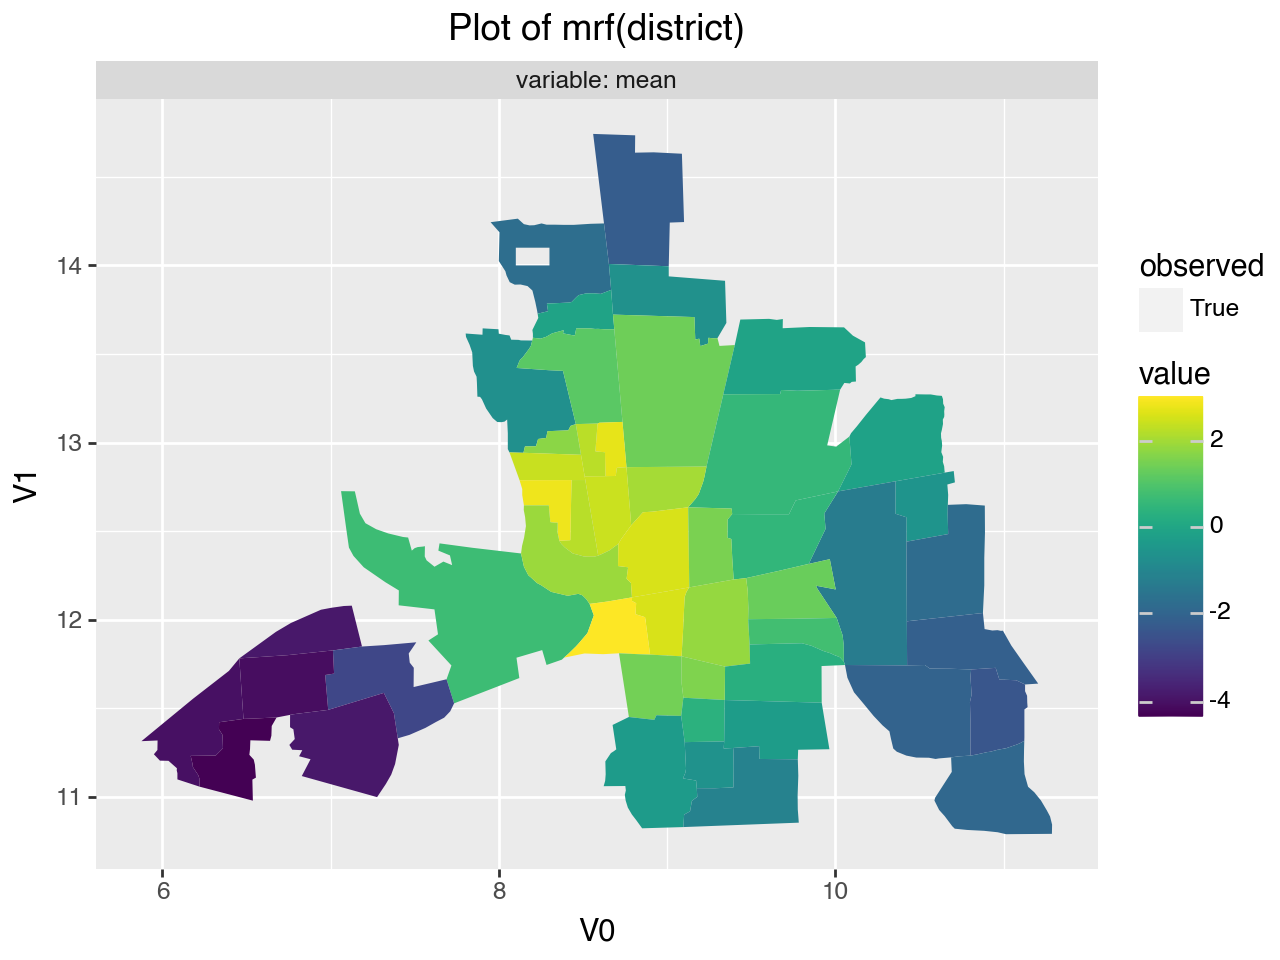

In [75]:
gam.plot_regions(
    term=loc.terms["mrf(district)"],
    samples=samples,
    # polys=polys, # since the term was created with polygons, no need to supply them
)

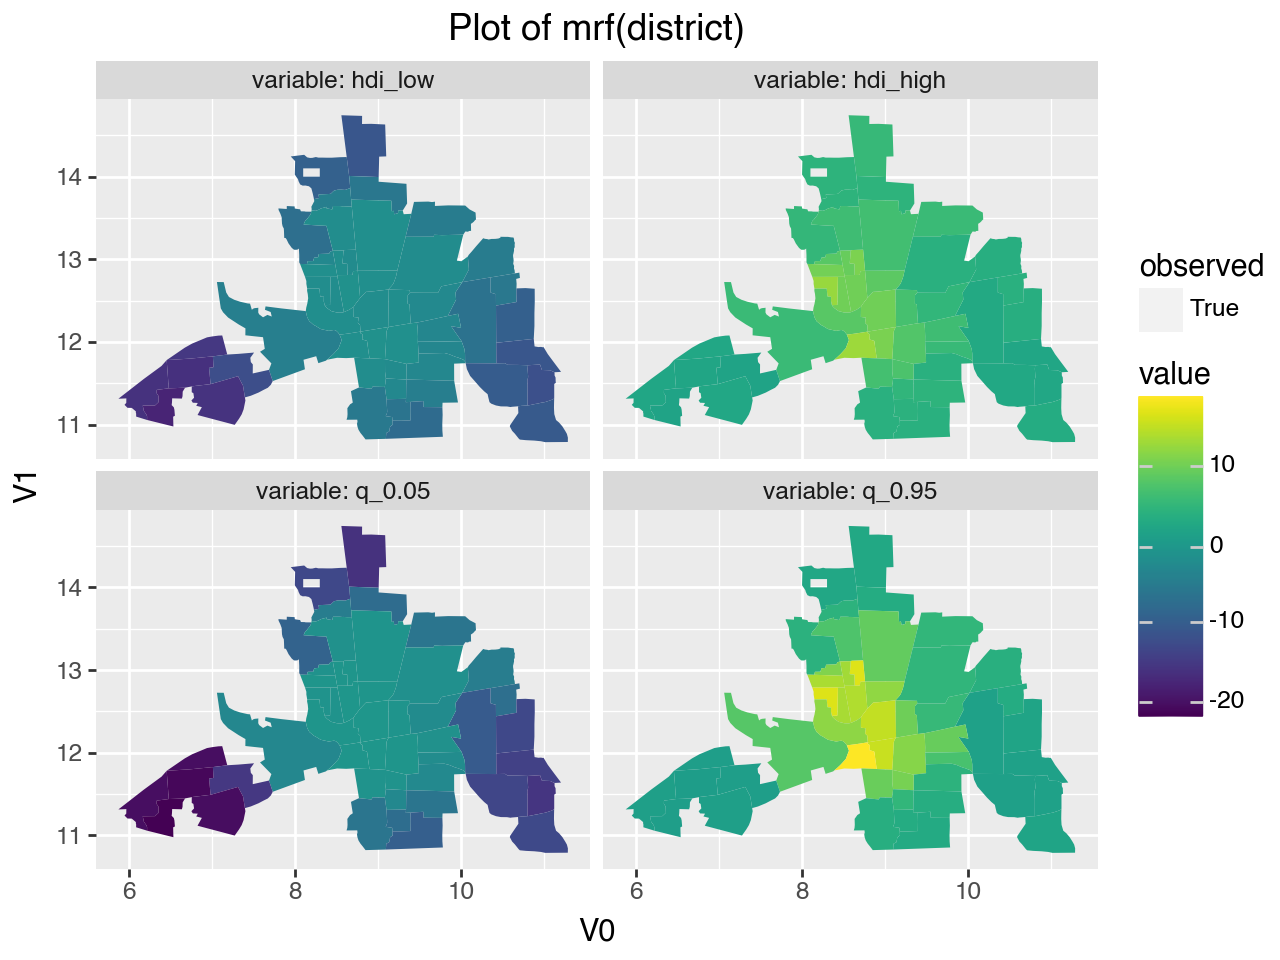

In [76]:
gam.plot_regions(
    term=loc.terms["mrf(district)"],
    samples=samples,
    # polys=polys, # since the term was created with polygons, no need to supply them
    which=["hdi_low", "hdi_high", "q_0.05", "q_0.95"],
)

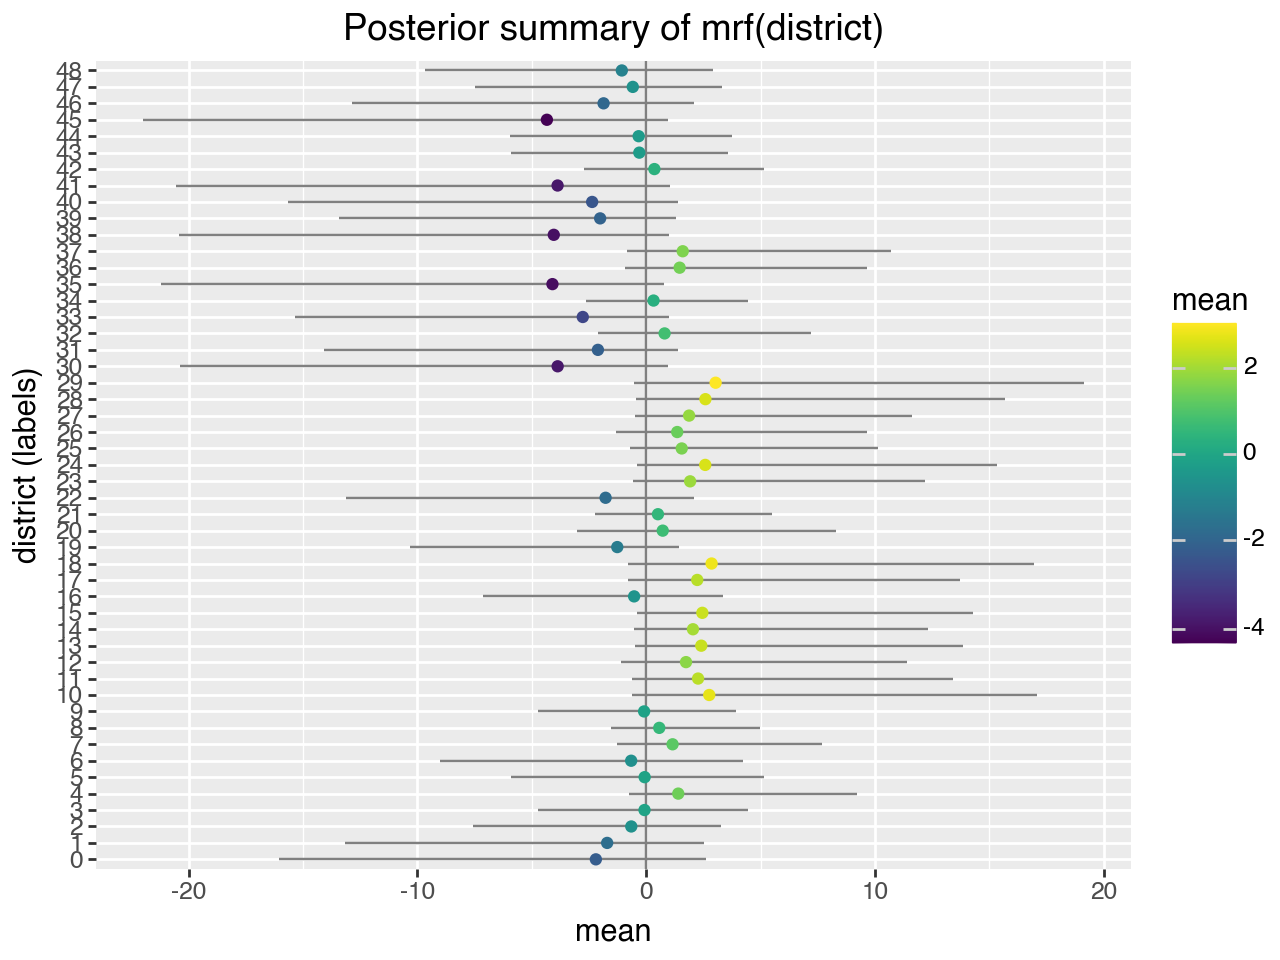

In [77]:
import plotnine as p9

gam.plot_forest(
    term=loc.terms["mrf(district)"],
    samples=samples,
    # labels=tb.bases.mappings["district"],
    ymin="q_0.05",
    ymax="q_0.95",
) + p9.aes(color="mean")